In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

from sklearn.model_selection import train_test_split
import os
import pickle
import random
import numpy as np
import itertools

Using TensorFlow backend.


# Captcha solver
## Stage 1: character counter

For this experiment, we will build the captcha solver in 2 separate stages. The first is to build a classifier than will determine the number of characters (before activating a stage 2 classification of the characters)


In [2]:
DATA_DIR = 'data'
DATA_DIR_VAL = 'data_val'
MODEL_NAME = 'char_counter_exp01.h5'
num_classes = 5

width = 150
height = 60 #Uniform squashing of images

#Convert to numpy for speed
import progressbar

def extractor(gen, name, folder):
    gen.reset()
    samples = gen.samples
    batch_size = gen.batch_size
    bar = progressbar.ProgressBar()
    #X = []
    
    for step in bar(range(samples//batch_size + 1)):
        X_batch, y_batch = gen.next()
        
        np.save(os.path.join(folder, '%s_X_%d.npy'%(name,step)), 
                X_batch)
        #X.append(X_batch)
        #y.append(y_batch)
        #if step == 0:
        #    X = X_batch
            #y = y_batch
        #else:
        #    X = np.concatenate((X, X_batch), axis=0)
            #y = np.concatenate((y, y_batch), axis=0)
        #X = np.concatenate(X, axis=0)
    #y = gen.classes
    y = y.classes
    np.save(os.path.join(folder, '%s_y.npy'%(name)), y)

datagen = ImageDataGenerator()
traingen = datagen.flow_from_directory('data',
                                      target_size=(height, width),
                                      batch_size=6000,
                                      shuffle=False)
valgen = datagen.flow_from_directory('data_val',
                                      target_size=(height, width),
                                      batch_size=6000,
                                      shuffle=False)
extractor(traingen, 'train', 'data_npy')
#X_train.save('X_train.npy', X_train)
#y_train.save('y_train.npy', y_train)

extractor(valgen, 'val', 'data_npy')
#X_val.save('X_val.npy', X_val)
#y_val.save('y_val.npy', y_val)





In [4]:
train_datagen = ImageDataGenerator(rescale=1/255,
                               shear_range=0.05,
                               channel_shift_range=0.2,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               fill_mode='reflect'
                              )

val_datagen = ImageDataGenerator(rescale=1/255,
                                fill_mode='reflect')



In [5]:
train_generator = train_datagen.flow_from_directory(DATA_DIR,
                                                   target_size=(height, width),
                                                    batch_size=64,
                                                   shuffle=True)
val_generator = val_datagen.flow_from_directory(DATA_DIR_VAL,
                                                  batch_size=64,
                                                target_size=(height, width),
                                                 shuffle=False)

Found 628532 images belonging to 5 classes.
Found 148757 images belonging to 5 classes.


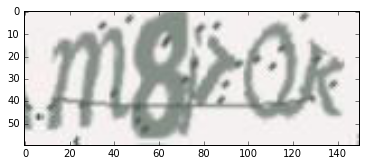

In [12]:
#Test some images
a, b = train_generator.next()
plt.imshow(a[0])


In [13]:
def mixed_block(x, num_filt, block_num):
    branch1x1 = Conv2D(num_filt, (1,1), activation='relu', padding='same', name='block%d_1x1_c1'%block_num)(x)
    branch1x1 = BatchNormalization(name='block%d_1x1_bn1'%block_num)(branch1x1)
    
    branch3x3 = Conv2D(int(num_filt*0.75), (1,1), activation='relu', padding='same', name='block%d_3x3_c1'%block_num)(x)
    branch3x3 = BatchNormalization( name='block%d_3x3_bn1'%block_num)(branch3x3)
    branch3x3 = Conv2D(num_filt, (3,3), activation='relu', padding='same', name='block%d_3x3_c2'%block_num)(branch3x3)
    branch3x3 = BatchNormalization( name='block%d_3x3_bn2'%block_num)(branch3x3)
    
    branch5x5 = Conv2D(int(num_filt*0.75), (1,1), activation='relu', padding='same', name='block%d_5x5_c1'%block_num)(x)
    branch5x5 = BatchNormalization(name='block%d_5x5_bn1'%block_num)(branch5x5)
    branch5x5 = Conv2D(num_filt, (3,3), activation='relu', padding='same', name='block%d_5x5_c2'%block_num)(branch5x5)
    branch5x5 = Conv2D(num_filt, (3,3), activation='relu', padding='same', name='block%d_5x5_c3'%block_num)(branch5x5)
    branch5x5 = BatchNormalization(name='block%d_5x5_bn2'%block_num)(branch5x5)    
    
    #branch5x5 = Conv2D(num_filt, (5,5), activation='relu', padding='same', name='block%d_5x5_c2'%block_num)(branch5x5)
    #branch5x5 = BatchNormalization(name='block%d_5x5_bn2'%block_num)(branch5x5)
    
    branch_pool = AveragePooling2D((3,3), strides=(1,1), padding='same', name='block%d_pool_pool1'%block_num)(x)
    branch_pool = Conv2D(int(num_filt//2), (1,1), activation='relu', name='block%d_pool_c1'%block_num)(branch_pool)
    
    out = Concatenate(name='mixed_%d'%block_num, axis=3)([branch1x1, branch3x3, branch5x5, branch_pool])
    return out

In [14]:
inps = Input(shape=(height, width, 3))
x = Conv2D(32, (3,3), activation='relu', name='conv1_c1')(inps)
x = BatchNormalization(name='conv1_bn1')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv1_c2')(x)
x = BatchNormalization(name='conv1_bn2')(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='conv1_pool1')(x)

x = Conv2D(128, (3,3), activation='relu', name='conv2_c1')(x)
x = BatchNormalization(name='conv2_bn1')(x)
x = Conv2D(192, (3,3), activation='relu', name='conv2_c2')(x)
x = BatchNormalization(name='conv2_bn2')(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='conv2_pool1')(x)
x = Dropout(0.1)(x)

x = Conv2D(256, (3,3), activation='relu', name='conv3_c1')(x)
x = BatchNormalization(name='conv3_bn1')(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='conv3_pool1')(x)
x = Dropout(0.2)(x)

x = mixed_block(x, 64, 0)
x = Dropout(0.4)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

logits_layer = Dense(num_classes, name= 'logits_layer')(x)
output = Activation('softmax',name = 'Sofftmax_layer')(logits_layer)

model = Model(inps, output)
model.summary()

# initiate RMSprop optimizer
opt = keras.optimizers.adam(decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 60, 150, 3)    0                                            
____________________________________________________________________________________________________
conv1_c1 (Conv2D)                (None, 58, 148, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
conv1_bn1 (BatchNormalization)   (None, 58, 148, 32)   128         conv1_c1[0][0]                   
____________________________________________________________________________________________________
conv1_c2 (Conv2D)                (None, 58, 148, 64)   18496       conv1_bn1[0][0]                  
___________________________________________________________________________________________

In [ ]:
train_generator.batch_size

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.8,
              patience=3, min_lr=0.00001)
model_chkpt = ModelCheckpoint(filepath=MODEL_NAME, monitor='val_acc', verbose=1, save_best_only=True)

epochs = 100

hist = model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // val_generator.batch_size,
                    workers=4,
                    callbacks=[reduce_lr, model_chkpt]) # , model_chkpt Weird serialization error

Epoch 1/100
9820/9820 [==============================] - 1817s - loss: 0.3503 - acc: 0.8674 - val_loss: 0.1547 - val_acc: 0.9493
Epoch 2/100
9820/9820 [==============================] - 1812s - loss: 0.1462 - acc: 0.9532 - val_loss: 0.1566 - val_acc: 0.9448
Epoch 3/100
9820/9820 [==============================] - 1761s - loss: 0.1083 - acc: 0.9659 - val_loss: 0.1779 - val_acc: 0.9395
Epoch 4/100
9820/9820 [==============================] - 1710s - loss: 0.0888 - acc: 0.9724 - val_loss: 1.3616 - val_acc: 0.6501
Epoch 5/100
9820/9820 [==============================] - 1699s - loss: 0.0762 - acc: 0.9767 - val_loss: 0.7499 - val_acc: 0.7945
Epoch 6/100
9820/9820 [==============================] - 1675s - loss: 0.0622 - acc: 0.9811 - val_loss: 0.0549 - val_acc: 0.9820
Epoch 7/100
4372/9820 [============>.................] - ETA: 924s - loss: 0.0578 - acc: 0.9829

KeyboardInterrupt: 